In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from Vector2D import Vector2D
from scipy.interpolate import CubicSpline
from numpy import deg2rad, rad2deg

In [5]:
# cam = cv2.VideoCapture(1)
# result, image = cam.read()
# plt.imshow(image)
# cam.release()

In [6]:
# Constants

circle_radius = 20
goal_center = Vector2D(640, 480/2)
H = 40

In [7]:
def make_triangle_vertices(base_center, H, angle):

    """Creates 3 vertices for a triangle

    Parameters
    ----------
    base_center: Vector2D
        Base center position to use for triangle
    H: number
        Triangle Height
    angle: number
        Triangle pointing direction in degrees

    Return
    ----------
    numpy.array
        an array of each of the 3 triangle's vertices
    """

    # Base lenght compared to height proportion
    base_prop = 1/3
    # Half base lenght
    l = H*base_prop 
    # Convert angle to radias
    rads = deg2rad(angle)
    # Get base center coordinates
    x = base_center.x
    y = base_center.y
    # Calculate base orientation
    a = deg2rad(angle - 90)
    # Create vertices array
    pts = np.array([(x+H*np.cos(rads), y+H*np.sin(rads)), (x+l*np.cos(a), y+l*np.sin(a)), (x-l*np.cos(a), y-l*np.sin(a))], dtype=int)
    pts = pts.reshape((-1, 1, 2))
    return pts

In [8]:
def draw_image(triangle_center, triangle_angle, circle_center):
    img = np.ones((480, 640, 3), dtype='uint8')*255
    cc_x = circle_center.x
    cc_y = circle_center.y
    tc_x = triangle_center.x
    tc_y = triangle_center.y
    triangle_vertices = make_triangle_vertices(triangle_center, H, triangle_angle)
    cv2.circle(img, (cc_x, cc_y), circle_radius, (255, 0, 0), -1)
    cv2.fillPoly(img, [triangle_vertices], (0, 0, 255))
    return img

-60


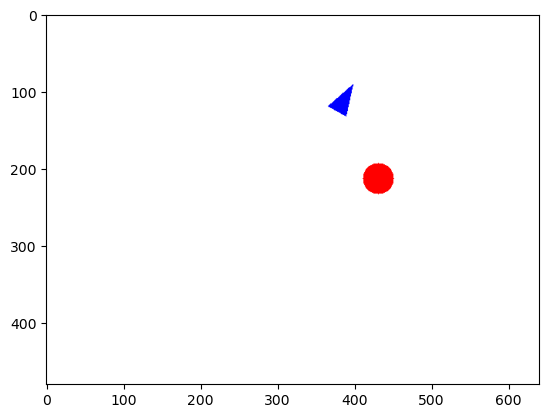

In [9]:
# Add padding to field
pad_field_x = 100+circle_radius
pad_field_y = 50+circle_radius

# Create random location for ball in the field
circle_center_x = np.random.randint(pad_field_x, 640 - pad_field_x)
circle_center_y = np.random.randint(pad_field_y, 480 - pad_field_y)
circle_center = Vector2D(circle_center_x, circle_center_y)

# Define triangle (car) orientation
angle = np.random.randint(-90, 90)
print(angle)

# Create random location for triangle in the field
triangle_center_x = np.random.randint(H*2, circle_center_x - 10)
triangle_center_y = np.random.randint(H*2, circle_center_y - 10)

# Turn location into Vector class
triangle_center = Vector2D(triangle_center_x, triangle_center_y)

img = draw_image(triangle_center, angle, circle_center)
plt.imshow(img)

https://www.geeksforgeeks.org/how-to-detect-shapes-in-images-in-python-using-opencv/

https://pyimagesearch.com/2016/02/08/opencv-shape-detection/

In [10]:
# converting image into grayscale image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
# setting threshold of gray image
_, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
  
# using a findContours() function
contours, _ = cv2.findContours(
    threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [11]:
def find_shapes(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # setting threshold of gray image
    _, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # using a findContours() function
    contours, _ = cv2.findContours(
        threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    i = 0

    shapes = []
    
    # list for storing names of shapes
    for contour in contours:
    
        # here we are ignoring first counter because 
        # findcontour function detects whole image as shape
        if i == 0:
            i = 1
            continue
    
        # cv2.approxPloyDP() function to approximate the shape
        approx = cv2.approxPolyDP(
            contour, 0.04 * cv2.arcLength(contour, True), True)
        
        # using drawContours() function
        # cv2.drawContours(img, [contour], 0, (0, 0, 255), 5)
    
        # finding center point of shape
        M = cv2.moments(contour)
        if M['m00'] != 0.0:
            x = int(M['m10']/M['m00'])
            y = int(M['m01']/M['m00'])

            shape = {'center': Vector2D(x, y)}
    
        # putting shape name at center of each shape
        if len(approx) == 3:
            shape['shape'] = 'triangle'
        else:
            shape['shape'] = 'circle'
        
        shapes.append(shape)

    for shape in shapes:
        if shape['shape'] == 'triangle':
            car_center = shape['center']
        if shape['shape'] == 'circle':
            ball_center = shape['center']
        
    return shapes

In [12]:
shapes = find_shapes(img)
for shape in shapes:
   if shape['shape'] == 'triangle':
      car_center = shape['center']
   if shape['shape'] == 'circle':
      ball_center = shape['center']

car_x0 = car_center.x
car_xf = ball_center.x
car_y0 = car_center.y
car_yf = ball_center.y

In [13]:
def get_line_function(Vec1,Vec2):
    x1 = Vec1.x
    x2 = Vec2.x
    y1 = Vec1.y
    y2 = Vec2.y

    m = (y2-y1)/(x2-x1)
    b = y1 - m*x1

    return lambda x: m*x + b

ball_goal_func = get_line_function(ball_center, goal_center)

In [14]:
def draw_trajectory(img, traj_func, from_, to_, color, thicnkess):
    traj_img = img.copy()
    traj_x = np.arange(from_.x, to_.x, 1)
    for i in range(len(traj_x) - 1):
        from_x = traj_x[i]
        to_x = traj_x[i+1]
        from_y = int(traj_func(from_x))
        to_y = int(traj_func(to_x))
        from_coord = (from_x, from_y)
        to_coord = (to_x, to_y)
        traj_img = cv2.line(traj_img, from_coord, to_coord, color, thicnkess)

    return traj_img

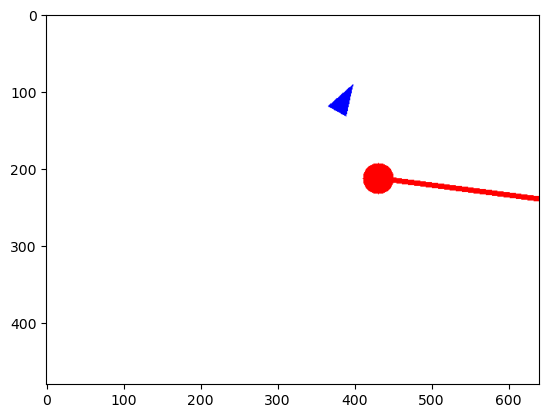

In [15]:
ball_goal_img = draw_trajectory(img, ball_goal_func, ball_center, goal_center, (255, 0, 0), 5)
plt.imshow(ball_goal_img)

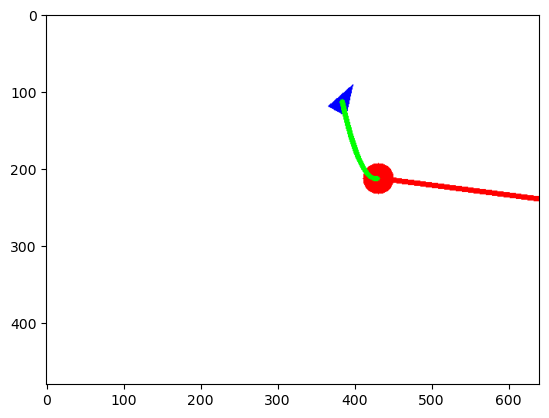

In [16]:
point3_x = ball_center.x - 10
point3_y = ball_goal_func(point3_x)
point3 = Vector2D(point3_x, point3_y)

spline_x = [car_center.x, point3.x, ball_center.x]
spline_y = [car_center.y, point3.y, ball_center.y]

spline = CubicSpline(spline_x, spline_y)

space = np.linspace(car_center.x, ball_center.x, 100)

car_traj_img = draw_trajectory(ball_goal_img, spline, car_center, ball_center, (0, 255, 0), 5)
plt.imshow(car_traj_img)

## Medir error

- Ubicar coche
- Medir diferencia posicionamiento en $y$

In [17]:
def get_error(img, spline):
    car_found = False
    shapes = find_shapes(img)
    for shape in shapes:
        if shape['shape'] == 'triangle':
            car_center = shape['center']
            car_found = True

    if car_found:
        if car_center.x >= car_x0-20 and car_center.x <= car_xf:
            return spline(car_center.x) - car_center.y
        else:
            print('Car out of trajectory')
    else:
        print('car not found')
        return None

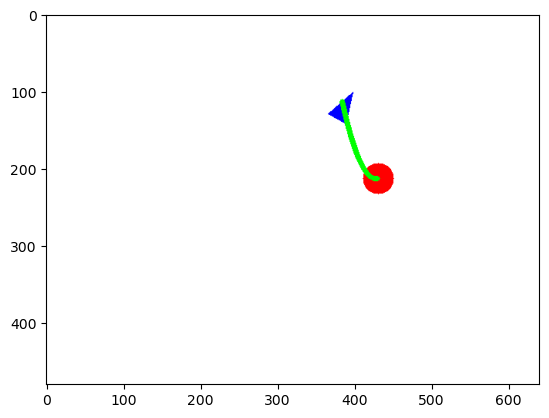

error: -10.0


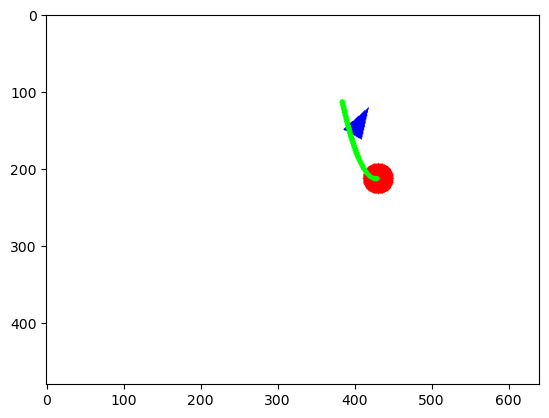

error: 40.68660149511214


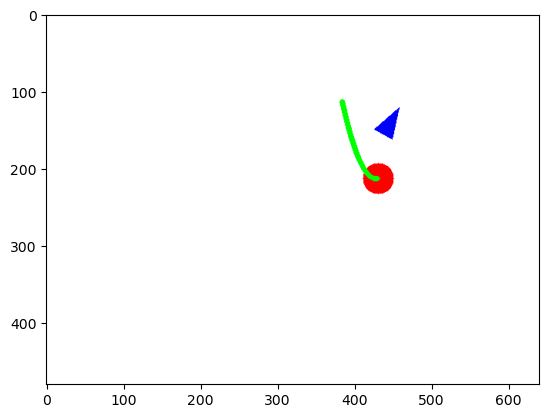

Car out of trajectory
error: None


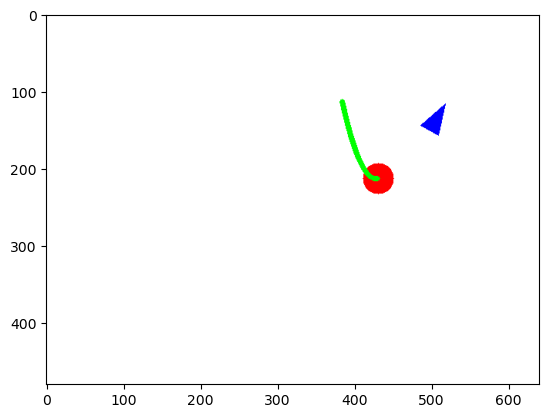

Car out of trajectory
error: None


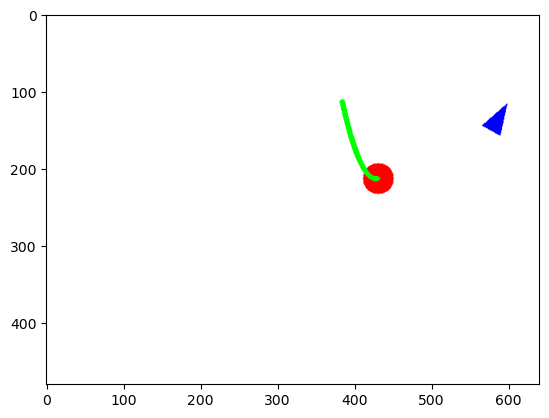

Car out of trajectory
error: None


In [18]:
x_move = np.array(list(range(5)), dtype=int)*20
y_move = [10, 20, 0, -5, 0]
for i in range(len(x_move)):
    triangle_center.move(x_move[i], y_move[i])
    img = draw_image(triangle_center, angle, circle_center)
    img_traj = img.copy()
    img_traj = draw_trajectory(img_traj, spline, Vector2D(car_x0, car_y0), circle_center, (0, 255, 0), 5)
    plt.imshow(img_traj)
    plt.show()
    e = get_error(img, spline)
    print(f'error: {e}')

## Orientación Triángulo

In [19]:
def get_angle(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return np.arctan((y2 - y1)/(x2 - x1))


def find_triangle_orientation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # setting threshold of gray image
    _, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # using a findContours() function
    contours, _ = cv2.findContours(
        threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    i = 0
    triangle_vertices = None

    shapes = []

    # list for storing names of shapes
    for contour in contours:

        # here we are ignoring first counter because 
        # findcontour function detects whole image as shape
        if i == 0:
            i = 1
            continue

        # cv2.approxPloyDP() function to approximate the shape
        approx = cv2.approxPolyDP(
            contour, 0.04 * cv2.arcLength(contour, True), True)

        if approx.shape[0] == 3:
            triangle_vertices = approx.reshape(3, 2)


    Lmin = np.inf
    # 0 = 1 - 2, 1 = 2 - 3, 2 = 3, 1
    shortest = 0
    excluded_points = [2, 0, 1]
    for i in range(3):
        if i == 2:
            i = -1
        x1, y1 = triangle_vertices[i]
        x2, y2 = triangle_vertices[i+1]
        L = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        if L < Lmin:
            Lmin = L
            shortest = i
            middle_point = ((x1+x2)/2, (y1+y2)/2)
    excluded_point = excluded_points[shortest] 
    direction_point = triangle_vertices[excluded_point]
    angle_direction = get_angle(middle_point, direction_point)
    return angle_direction

In [20]:
orientation = find_triangle_orientation(img)
rad2deg(orientation)

-59.743562836470744

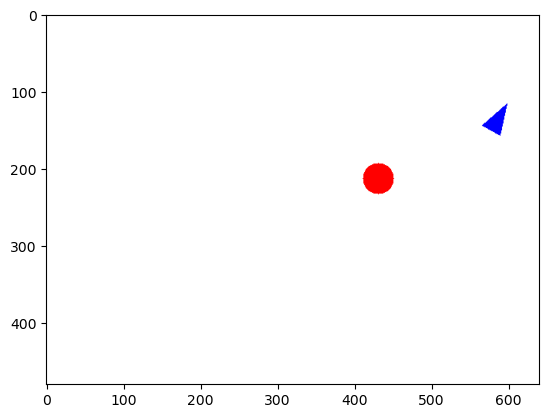

In [21]:
plt.imshow(img)

## Orientación Inicial Spline



In [22]:
ref_angle = get_angle((car_x0, car_y0), (car_x0 + 10, spline(car_x0+10)))
rad2deg(ref_angle)

76.14780461009902

In [ ]:
def get_angle_error(ref_angle, img):
    return int(ref_angle - find_triangle_orientation(img))

